# [Title]
This is a single notebook to reproduce the results in the final version of the NIPS paper [Deep, complex, invertible networks for inversion of transmission effects in multimode optical fibres] using PyTorch.

# PART 1 : Pytorch models building, training and testing

## 1.1 General setup

In [1]:
%%time 
# Change to appropriate path
my_path = ''


import os
import gc

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 0

import numpy as np
import pickle
import h5py
import cv2
from IPython.display import display, clear_output
from copy import copy
from matplotlib import colors

from ComplexNetsTorch import *

import subprocess
import imageio
from IPython.display import HTML

def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
new_folders = ['figures', 'gifs', 'models']
for new_folder in new_folders:
    if not os.path.isdir(new_folder): 
        os.makedirs(new_folder)

Wall time: 4.79 s


## 1.2 Load data
#### 1.2.1 The input images loaded have amplitudes of 0 to 1 per pixel, and the speckle images have amplitude 0 to 255

Loading digi ...
Loading fash ...
Loading rand ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...


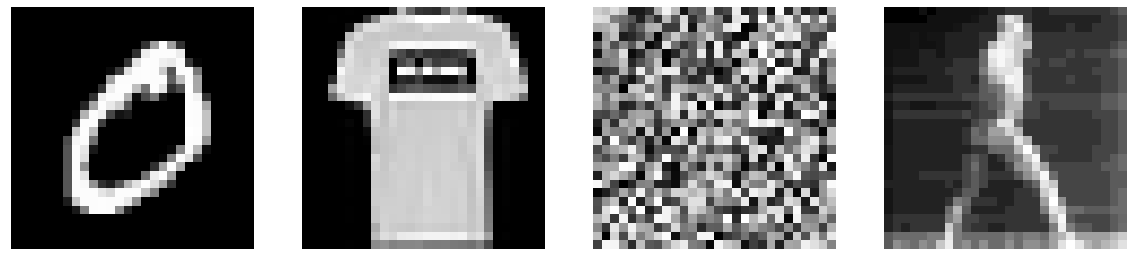

In [2]:
out_dim = 28
speckle_dim = 112 #56
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File( my_path + file_location , 'r')


# Original/input image filenames, just renaming the handles for ease I guess
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                      'fash_test': 'Testing/Original_images/MNIST',
                      'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

#They are creating empty datasets named digi, fash, etc..
#The output is orig_imgs dictionary having "digi": then the dataset, "fash": then the dataset and so on
orig_imgs = {dataset: None for dataset in orig_img_filenames}

#They are filling these datasets in the "orig_imgs" dictionary as np arrays
for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)


## TRAIN
#Put all the datasets into one big dataset, y_train has 44000 training examples
#Dimensions of y_train is 44000 x (28x28) x 1; the x 1 is a trivial dimension, should be removed by np.squeeze
y_train = np.concatenate((orig_imgs['digi'],
                          orig_imgs['fash'],
                          orig_imgs['rand'],
                         ))

#Flatten the images, now y_train dimensions are 44000 x 784
y_train = np.squeeze(y_train.reshape(-1, 28*28, 1)) #-1 means infer that dimension. The x 1 dimension is removed by squeezing

## TEST
y_test = np.concatenate((orig_imgs['digi_test'],
                         orig_imgs['fash_test'],))

#y_test now has the dimensions of 6000x784
y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))


## Example of each dataset
rows, cols = 1, len(orig_img_filenames)-2 # exclude test sets
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 10))
ex = 1

i = 1
for name in (name for name in orig_img_filenames if 'test' not in name):
    plt.subplot(rows, cols, i)
    plt.imshow(orig_imgs[name][ex].reshape(28,28)) #reshaping examples as 2D arrays, to be able to draw them by plt.imshow
    axes_off()
    i+=1




# Load and resize all datasets

# Original/input image filenames
speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'rand': 'Training/Speckle_images/Random Patterns',
                      'fash_test': 'Testing/Speckle_images/MNIST',
                      'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'}

data_dict = {dataset: None for dataset in speckle_img_filenames}


# import speckle images and resize them from 224 to the chosen speckle_dim
for dataset, filename in speckle_img_filenames.items():
    print(f"Loading {dataset} ...")
    # Load
    fl = hf[filename]
    data_dict[dataset] =  np.array(fl)
    #To resize we recover the original image shape
    #data_dict[dataset].shape[0] is used instead of -1 in the reshape function, which means it is calculated, not inferred
    #cv2 resizer method needs the input as image (2D array) and not flattened
    Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224))
    
    #Temp array with the new dimensions, but it is flattened here
    Data_temp = np.zeros((data_dict[dataset].shape[0],speckle_dim*speckle_dim))
    # Resize
    for im in range(data_dict[dataset].shape[0]):
        #resize using cv2, then reshape as flattened and put in Data_temp
        Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(speckle_dim, speckle_dim), interpolation=cv2.INTER_AREA), (speckle_dim*speckle_dim))
    
    data_dict[dataset] = Data_temp            
    del Data_temp, Data_resize
    gc.collect()


#TRAIN
#x_train now has the dimensions of 44000x12544
x_train = np.concatenate((data_dict['digi'],
                          data_dict['fash'],
                          data_dict['rand'],
                         ))
# TEST
#x_test now has the dimensions of 6000x12544
x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],))

#x_test_ch now has the dimensions of 6000x12544x2
x_train_ch = real_to_channels_np(x_train.astype('float32'))
x_test_ch  = real_to_channels_np(x_test.astype('float32'))

hf.close()

### 1.2.2 Apply the nonlinear transformation that the SLM induces on amplitude and phase.
### After this cell, input images have amplitudes 0 to 255 per pixel

In [3]:
from scipy import interpolate

experimentalAmp   = np.load(my_path + 'amplitude.npy')

#The phases here are the actual phases in radian divided by pi
experimentalPhase = np.load(my_path + 'phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

#x1 and x2 are arrays from 0 to 1, they have length of 101 (as pixel values range from 0 to 100, or 0 to 1 if normalized)
x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
#testx = np.arange(0.0,100.0,0.5)/100.0

#Create interpolate objects, supply x and y, then supply the new x later
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


print(np.min(y_train), np.max(y_train))

#I don't understand why they scale the phases, maybe to make all of the features have the same numerical range
y_train_phase = fSLMphase(y_train)*255.0
y_test_phase  = fSLMphase(y_test)*255.0

#scale the pixel amplitudes to be 0 to 255, now they are just like the speckle amplitudes
y_train       = fSLMamp(y_train)*255.0
y_test        = fSLMamp(y_test)*255.0
print(np.min(y_train), np.max(y_train))

101 101
0.0 1.0
3.113248752079867 255.0


## 1.3 PyTorch Models

### 1.3.1 Imports and check CUDA

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Check if CUDA is available and get the CUDA device name
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Using cuda device
NVIDIA GeForce RTX 3080 Ti


### 1.3.2 Define custom layers

In [5]:
class MyAmplitude(nn.Module):
    """ Custom Amplitude layer """
    def __init__(self):
        super().__init__()

    def forward(self,x):
        complex_x = (channels_to_complex(x) if x.shape[-1] == 2 else x)
        output = torch.abs(complex_x)
        return output
    
class MyReshape(nn.Module): 
    """ Custom Reshape layer """
    def __init__(self, d1, d2): 
        super(MyReshape, self).__init__() 
        self.d1 = d1
        self.d2 = d2
        
    def forward(self, x): 
        if len(x.shape) == 2:
            return x.view(x.shape[0], self.d1, self.d2) 
        elif len(x.shape) == 3:
            return x.view(x.shape[0], self.d1, self.d2, 2)
    
    def extra_repr(self):
        return 'in_size={}, out_size={}x{}'.format(self.d1*self.d2, self.d1, self.d2)

class MyHadamard(nn.Module):
    """ Custom Hadamard layer """
    def __init__(self, size_in):
        super().__init__()
        self.size_in = size_in
        
        # define weights
        weights = torch.Tensor(size_in)
        self.weights = nn.Parameter(weights) 

        # initialize weights
        nn.init.ones_(self.weights) # weight init

    def forward(self, x):  
        x = x.float()
        if len(x.shape) == 3:
            return complex_to_channels(channels_to_complex(x) * torch.complex(self.weights, 0*self.weights))
        else:
            return x*self.weights
        
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(self.size_in, self.size_in) 
    
class MyLinear(nn.Module):
    """ Custom Linear Dense layer """
    def __init__(self, size_in, size_out, use_bias = False):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        self.use_bias = use_bias
        
        # define weights and biases
        weights = torch.Tensor(size_in, size_out)
        bias = torch.Tensor(size_out)
        self.weights = nn.Parameter(weights) 
        self.bias = nn.Parameter(bias) 

        # weights init, golort uniform
        limit = math.sqrt(6 / (self.size_in + self.size_out))
        torch.nn.init.uniform_(self.weights, a = -limit, b = limit)
        
        # bias init
        torch.nn.init.zeros_(self.bias)

    def forward(self, x):
        x = x.float()
        w = self.weights
        b = self.bias
        
        if self.use_bias == True:
            w_times_x_add_b = x @ w + b
        else:
            w_times_x_add_b = x @ w
        
        return w_times_x_add_b
    
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(self.size_in, self.size_out)    
        
class MyComplexDense(nn.Module):
    """ Custom Complex Dense layer """
    def __init__(self, size_in, size_out, use_bias = False):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        self.use_bias = use_bias
        
        # define weights and biases
        weights = torch.Tensor(size_in, size_out, 2)
        bias = torch.Tensor(size_out, 2)
        self.weights = nn.Parameter(weights) 
        self.bias = nn.Parameter(bias) 

        # weights init, golort uniform
        limit = math.sqrt(6 / (self.size_in + self.size_out))
        torch.nn.init.uniform_(self.weights, a = -limit, b = limit)
        
        # bias init
        torch.nn.init.zeros_(self.bias)

    def forward(self, x):
        x = x.float()
        w = channels_to_complex(self.weights)
        b = channels_to_complex(self.bias)
        x = channels_to_complex(x)
        
        if self.use_bias == True:
            w_times_x_add_b = x @ w + b
        else:
            w_times_x_add_b = x @ w
            
        return complex_to_channels(w_times_x_add_b)
    
    def extra_repr(self):
        return 'in_features={}, out_features={}'.format(self.size_in, self.size_out)

### 1.3.3 Define SSIM loss module, adapted from pytorch-msssim package to return the loss directly

In [6]:
def _fspecial_gauss_1d(size, sigma):
    r"""Create 1-D gauss kernel
    Args:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)

class SSIM_loss(torch.nn.Module):
    def __init__(
        self,
        data_range=255,
        size_average=True,
        win_size=11,
        win_sigma=1.5,
        channel=3,
        spatial_dims=2,
        K=(0.01, 0.03),
        nonnegative_ssim=False,
        mul = 1,
    ):
        r""" class for ssim
        Args:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
            nonnegative_ssim (bool, optional): force the ssim response to be nonnegative with relu.
        """

        super(SSIM_loss, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.size_average = size_average
        self.data_range = data_range
        self.K = K
        self.nonnegative_ssim = nonnegative_ssim
        self.mul = mul

    def forward(self, X, Y):
        return self.mul-self.mul*ssim(
            X.reshape(-1, 1, 28, 28),
            Y.reshape(-1, 1, 28, 28),
            data_range=self.data_range,
            size_average=self.size_average,
            win=self.win,
            K=self.K,
            nonnegative_ssim=self.nonnegative_ssim,
        )

### 1.3.4 Define train, test, validation and test_display functions

In [7]:
def train(model, epochs, optimizer, scheduler, loss, reg, lamb, train_loader, patience, min_delta):
    # Early stopping
    the_last_loss = 1e10
    trigger_times = 0
    
    # Train loop
    model.train()
    indx_epoch = 1
    for epoch in range(epochs): 
        indx_batch = 1
        for data in train_loader:  
            x, y0, y1, y2 = data
            x = x.to(device)
            y0 = y0.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            model.zero_grad()  
            output = model(x) 
            
            # Multi-resolution loss
            if isinstance(output, tuple) == False:
                loss_value = loss(output, y0)
            elif isinstance(output, tuple) == True:
                loss_value = loss(output[0], y0) + loss(output[1], y1) + loss(output[2], y2)
            
            # Regularization
            if reg == 'L2':
                loss_value = loss_value + lamb * torch.sum(torch.square(model.fc.weights.data))
            elif reg == 'Unitary':
                if len(model.fc.weights.data.shape) == 2:
                    W = model.fc.weights.data
                    W_T = torch.transpose(W, 0, 1)
                    I = torch.eye(W.shape[1]).to(device)
                    loss_value = loss_value + lamb * torch.sum(torch.abs(W_T @ W - I))
                elif len(model.fc.weights.data.shape) == 3:
                    complex_W = channels_to_complex(model.fc.weights.data)
                    complex_W_conj_T = torch.transpose(torch.conj(complex_W), 0, 1)
                    I = torch.eye(complex_W.shape[1]).to(device)
                    loss_value = loss_value + lamb * torch.sum(torch.abs(complex_W_conj_T @ complex_W - I))
            
            # Backpropagate with Hadamard weights constrained
            loss_value.backward()  
            optimizer.step()  
            with torch.no_grad():
                model.hadamard.weights.copy_(model.hadamard.weights.data.clamp(min=0.01, max = 1))

            print('Batch: {}/{}, Running Loss = {}'.format(indx_batch, len(train_loader), loss_value), end="\r") 
            indx_batch = indx_batch + 1
        
        # Loss over training dataset for this epoch OR Latest training loss
        train_loss = valid(model = model, valid_loader = train_loader, loss = loss)
        print('Epoch: {}/{}, The current training loss = {}'.format(indx_epoch, epochs, train_loss))
        # print('Epoch: {}/{}, Latest training loss = {}'.format(indx_epoch, epochs, loss_value))
        indx_epoch = indx_epoch + 1
        
        # Reduce learning rate
        #scheduler.step(train_loss)
        
        # Early stopping, Loss over valiation dataset for this epoch
        the_current_loss = valid(model = model, valid_loader = test_loader, loss = loss)
        print('The current validation loss:', the_current_loss)

        if the_current_loss > the_last_loss-min_delta:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss
        
def test(model, test_loader, loss):
    # Settings
    model.eval()
    loss_total = 0

    # Test data
    with torch.no_grad():
        for data in test_loader:
            x, y0, y1, y2 = data
            x = x.to(device)
            y0 = y0.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            
            output = model(x)
            # Multi-resolution loss, but look at the original only
            if isinstance(output, tuple) == False:
                loss_value = loss(output, y0)
            elif isinstance(output, tuple) == True:
                loss_value = loss(output[0], y0)
            loss_total += loss_value.item()
            
    MSE = loss_total / len(test_loader)
    print(f"Test MSE = {MSE}\n")
    
    return MSE  
    
def valid(model, valid_loader, loss):
    # Settings
    model.eval()
    loss_total = 0

    # Validation data
    with torch.no_grad():
        for data in valid_loader:
            x, y0, y1, y2 = data
            x = x.to(device)
            y0 = y0.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            
            output = model(x)
            # Multi-resolution loss, but look at the original only
            if isinstance(output, tuple) == False:
                loss_value = loss(output, y0)
            elif isinstance(output, tuple) == True:
                loss_value = loss(output[0], y0)
            loss_total += loss_value.item()
    return loss_total / len(valid_loader) 

def test_display(model, x_test_all, y_test_all, out_dim=28, speckle_dim = 112, vmax=255.0):
    model.eval()
    x = torch.tensor(x_test_all).to(device)
    y = torch.tensor(y_test_all)
    
    output = model(x)
    if isinstance(output, tuple) == False:
        output = output.cpu()
    if isinstance(output, tuple) == True:
        output = output[0].cpu()
    
    rows = 4
    f, ax_arr = plt.subplots(rows, 3, figsize=(20, 20))

    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
    palette.set_under('g', 1.0)
    palette.set_bad('b', 1.0)
    
    idxs = [0,1,3004,4001]
    for row in range(1,rows+1):
        # Original
        plt.subplot(rows,3, 3*row-2)
        this_image = y[idxs[row-1]].reshape(out_dim,out_dim)        
        plt.imshow(this_image,
                  norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
        if row == 1: plt.title('Original images', fontsize=30, y=1.12)
        axes_off()

        # Speckle
        plt.subplot(rows,3,3*row-2 + 1)
        this_image = x_test_ch[idxs[row-1],:,0].reshape(speckle_dim, speckle_dim)        
        plt.imshow(this_image)
        if row == 1: plt.title('Speckle images', fontsize=30, y=1.12)
        axes_off()

        # Reconstructed
        plt.subplot(rows,3,3*row-2 + 2)
        this_image = output[idxs[row-1]].detach().numpy().reshape(out_dim,out_dim)
        plt.imshow(this_image,
                  norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
        if row == 1: plt.title('Reconstructed images', fontsize=30, y=1.12)
        axes_off()

### 1.3.5 Load datasets into Pytorch loaders

In [8]:
# Pyramidize the target images for mutli-resolution training
base_img_size = 28
def pyramidize(imgs, levels):
    
    # get images into right shape
    imgs = np.reshape(imgs, (imgs.shape[0], base_img_size, base_img_size))
    
    # do resizing
    resized_imgs = [np.array([cv2.resize(img, dsize=(int(base_img_size//2**i), 
                    int(base_img_size//2**i))) for img in imgs]) for i in range(levels)]
    
    return [np.reshape(size, (imgs.shape[0], int(imgs.shape[1]//2**i)**2))
            for i, size in enumerate(resized_imgs)]
    
y_train_p = pyramidize(y_train, levels=3)
y_test_p  = pyramidize(y_test, levels=3)


# Load datasets into a loader
batch_size = 64
class SpeckleDataset(Dataset):
    def __init__(self, X, Y0, Y1, Y2):
        self.X = torch.tensor(X).float()
        self.Y0 = torch.tensor(Y0).float()
        self.Y1 = torch.tensor(Y1).float()
        self.Y2 = torch.tensor(Y2).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx], self.Y0[idx], self.Y1[idx], self.Y2[idx])

train_set = SpeckleDataset(x_train_ch, y_train_p[0], y_train_p[1], y_train_p[2])
test_set = SpeckleDataset(x_test_ch, y_test_p[0], y_test_p[1], y_test_p[2])

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

# Clear what you don't need to free memory
del y_train, y_train_p, x_train, x_train_ch, y_test_p

### 1.3.6 Building different models

### 1.3.6.1 Model_1: Real layer with no regularization

Net(
  (amplitude): MyAmplitude()
  (fc): MyLinear(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
)
Epoch: 1/1000, The current training loss = 5931.862931362418
The current validation loss: 3689.925890334109
trigger times: 0
Epoch: 2/1000, The current training loss = 5435.592214894849
The current validation loss: 3135.5744758768283
trigger times: 0
Epoch: 3/1000, The current training loss = 5136.467458325763
The current validation loss: 2812.49628075133
trigger times: 0
Epoch: 4/1000, The current training loss = 4900.200472454692
The current validation loss: 2598.7630797041224
trigger times: 0
Epoch: 5/1000, The current training loss = 4713.135454399641
The current validation loss: 2415.4430191364695
trigger times: 0
Epoch: 6/1000, The current training loss = 4596.504401983217
The current validation loss: 2301.66928295379
trigger times: 0
Epoch: 7/1000, The current training loss = 4476.295767495799
The current validation loss: 2200.6650

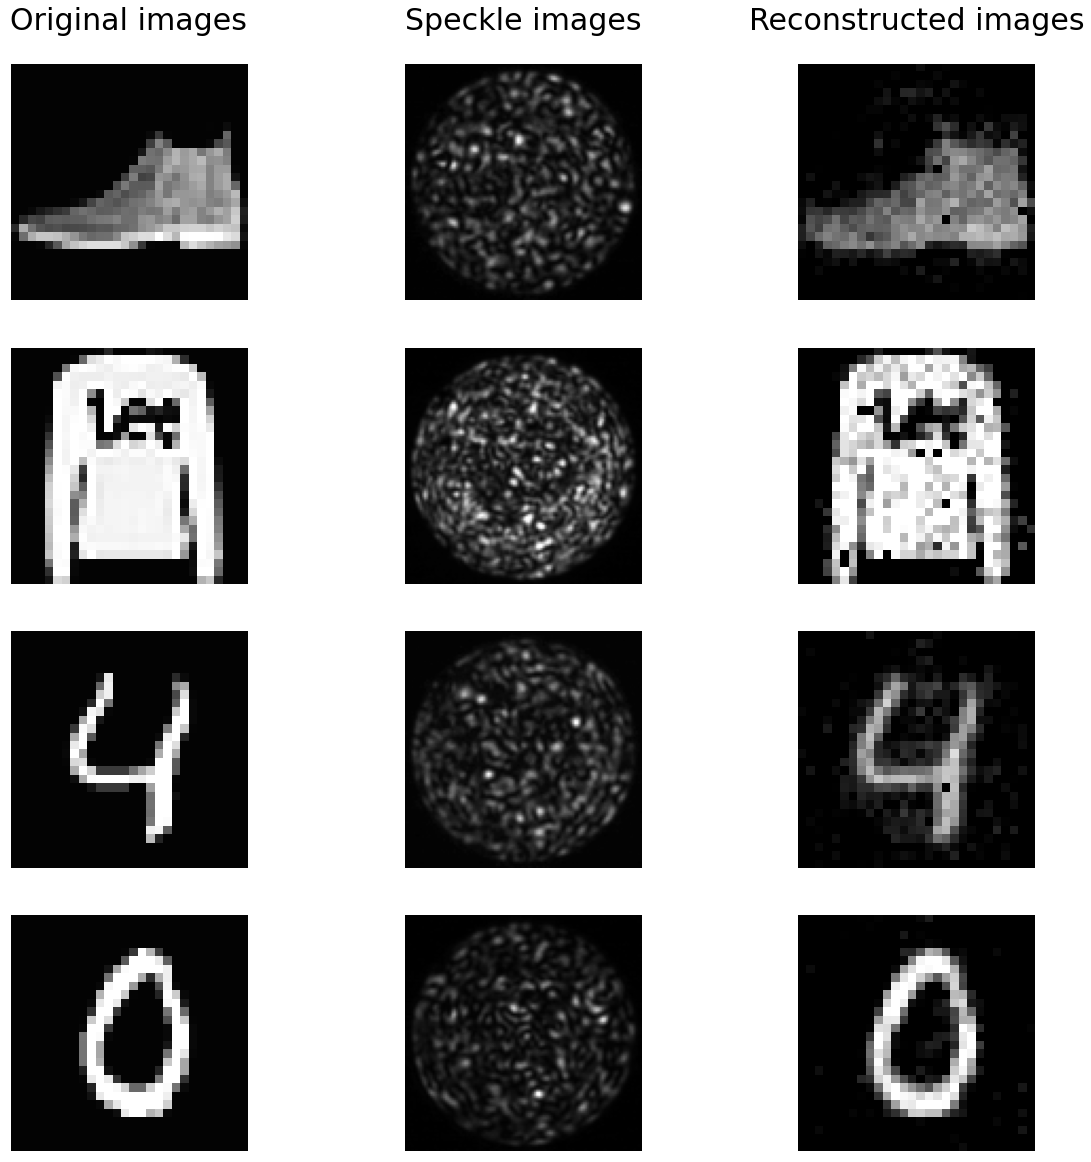

In [9]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.amplitude = MyAmplitude()
        self.fc = MyLinear(12544, 784)
        self.hadamard = MyHadamard(784)

    def forward(self, x):
        x = self.amplitude(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Real_no_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'None', lamb = 0, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_relu'.format(epochs))

#Test the model
#net = torch.load('models/' +model_name + '_epoch_{}'.format(epochs)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.2 Model_2: Real layer with L2 regularization

Net(
  (amplitude): MyAmplitude()
  (fc): MyLinear(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
)
Epoch: 1/1000, The current training loss = 5895.282564384993
The current validation loss: 3613.3648837475066
trigger times: 0
Epoch: 2/1000, The current training loss = 5443.540266170058
The current validation loss: 3076.147925843584
trigger times: 0
Epoch: 3/1000, The current training loss = 5158.512954357058
The current validation loss: 2762.248550739694
trigger times: 0
Epoch: 4/1000, The current training loss = 4939.418033688567
The current validation loss: 2542.955239153923
trigger times: 0
Epoch: 5/1000, The current training loss = 4804.302894414857
The current validation loss: 2402.14933874252
trigger times: 0
Epoch: 6/1000, The current training loss = 4682.511646714322
The current validation loss: 2290.5492540724736
trigger times: 0
Epoch: 7/1000, The current training loss = 4574.316582968068
The current validation loss: 2198.5312

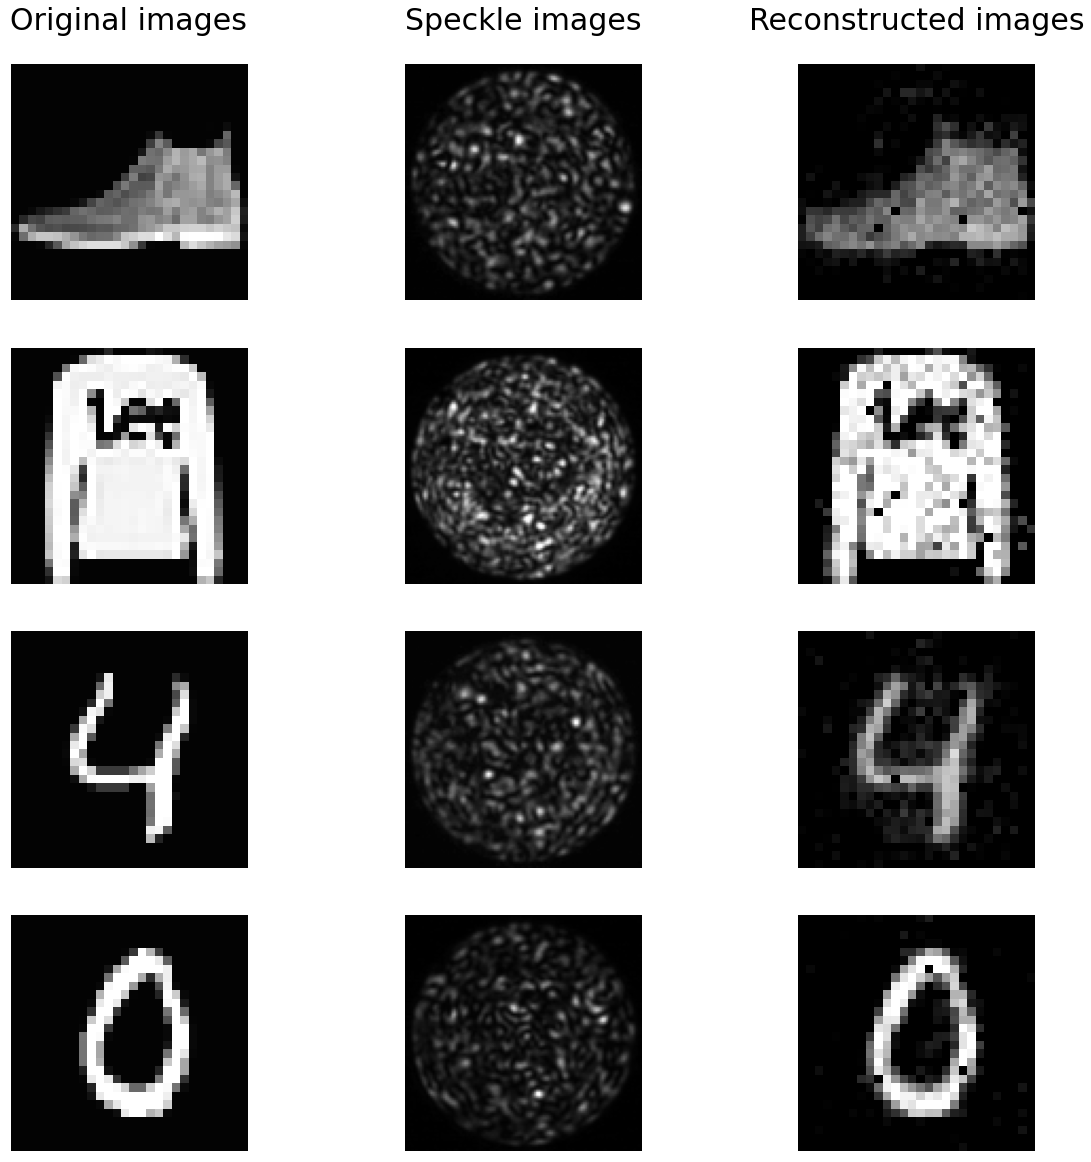

In [9]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.amplitude = MyAmplitude()
        self.fc = MyLinear(12544, 784)
        self.hadamard = MyHadamard(784)

    def forward(self, x):
        x = self.amplitude(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Real_L2_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
lamb = 0.03
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'L2', lamb = lamb, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_lamb_{}_relu'.format(epochs, lamb))

#Test the model
#net = torch.load('models/' + model_name + '_epoch_{}_lamb_{}'.format(epochs, lamb)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.3 Model_3: Complex layer with no regularization

Net(
  (fc): MyComplexDense(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
  (amplitude): MyAmplitude()
)
Epoch: 1/1000, The current training loss = 5246.057573895122
The current validation loss: 3225.6658597905584
trigger times: 0
Epoch: 2/1000, The current training loss = 4832.786029549532
The current validation loss: 2712.7708558427526
trigger times: 0
Epoch: 3/1000, The current training loss = 4583.811879357626
The current validation loss: 2429.407320063165
trigger times: 0
Epoch: 4/1000, The current training loss = 4401.666778919309
The current validation loss: 2235.5816962059507
trigger times: 0
Epoch: 5/1000, The current training loss = 4254.182012513626
The current validation loss: 2094.9071642287236
trigger times: 0
Epoch: 6/1000, The current training loss = 4138.965003435002
The current validation loss: 1981.0420649102393
trigger times: 0
Epoch: 7/1000, The current training loss = 4037.965219187182
The current validation loss:

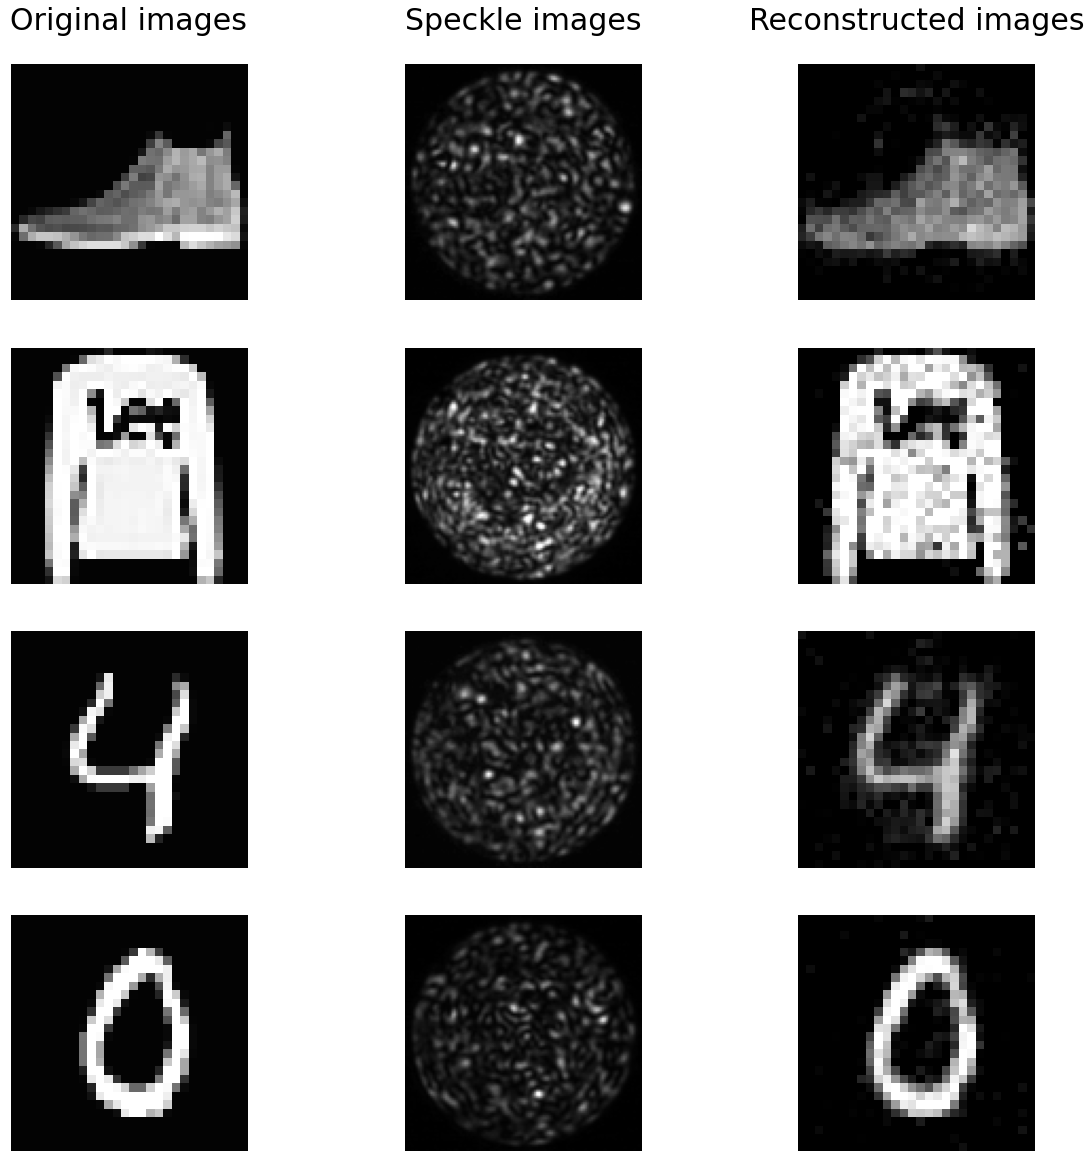

In [10]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = MyComplexDense(12544, 784)
        self.hadamard = MyHadamard(784)
        self.amplitude = MyAmplitude()

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        x = self.amplitude(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Complex_no_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'None', lamb = 0, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_relu'.format(epochs))

#Test the model
#net = torch.load('models/' + model_name + '_epoch_{}'.format(epochs)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.4 Model_4: Complex layer with L2 regularization

Net(
  (fc): MyComplexDense(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
  (amplitude): MyAmplitude()
)
Epoch: 1/1000, The current training loss = 5227.492312409157
The current validation loss: 3227.456275452959
trigger times: 0
Epoch: 2/1000, The current training loss = 4818.163484440293
The current validation loss: 2716.5950330369014
trigger times: 0
Epoch: 3/1000, The current training loss = 4580.951503664948
The current validation loss: 2433.7416005236037
trigger times: 0
Epoch: 4/1000, The current training loss = 4409.63026960506
The current validation loss: 2241.696616314827
trigger times: 0
Epoch: 5/1000, The current training loss = 4266.929369904275
The current validation loss: 2097.977798786569
trigger times: 0
Epoch: 6/1000, The current training loss = 4143.147780662359
The current validation loss: 1990.4015412026263
trigger times: 0
Epoch: 7/1000, The current training loss = 4042.1934363786563
The current validation loss: 1

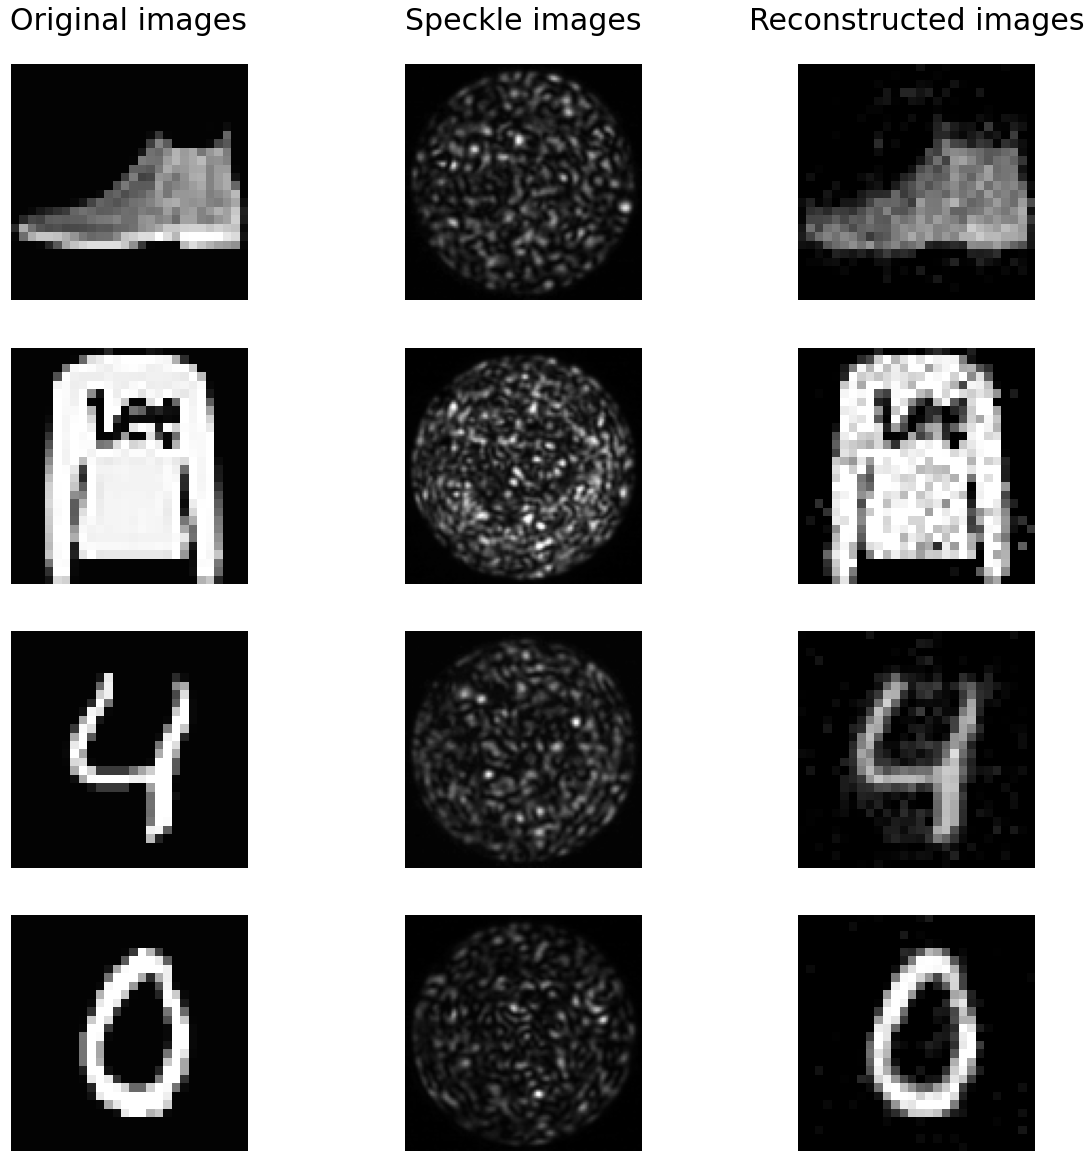

In [11]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = MyComplexDense(12544, 784)
        self.hadamard = MyHadamard(784)
        self.amplitude = MyAmplitude()

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        x = self.amplitude(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Complex_L2_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
lamb = 0.03
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'L2', lamb = lamb, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_lamb_{}_relu'.format(epochs, lamb))

#Test the model
#net = torch.load('models/' + model_name + '_epoch_{}_lamb_{}'.format(epochs, lamb)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.5 Model_5: Complex layer with L2 regularization but with SSIM loss instead of MSE loss

Net(
  (fc): MyComplexDense(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
  (amplitude): MyAmplitude()
)
Epoch: 1/1000, The current training loss = 13162.781308196312
The current validation loss: 9540.39878033577
trigger times: 0
Epoch: 2/1000, The current training loss = 11229.749788506086
The current validation loss: 7598.42499168883
trigger times: 0
Epoch: 3/1000, The current training loss = 10047.14329493323
The current validation loss: 6631.724276928191
trigger times: 0
Epoch: 4/1000, The current training loss = 9122.010080736736
The current validation loss: 5949.675604637633
trigger times: 0
Epoch: 5/1000, The current training loss = 8446.392446118733
The current validation loss: 5502.83552194149
trigger times: 0
Epoch: 6/1000, The current training loss = 7932.284066133721
The current validation loss: 5229.01604055851
trigger times: 0
Epoch: 7/1000, The current training loss = 7528.0066287018535
The current validation loss: 5000.

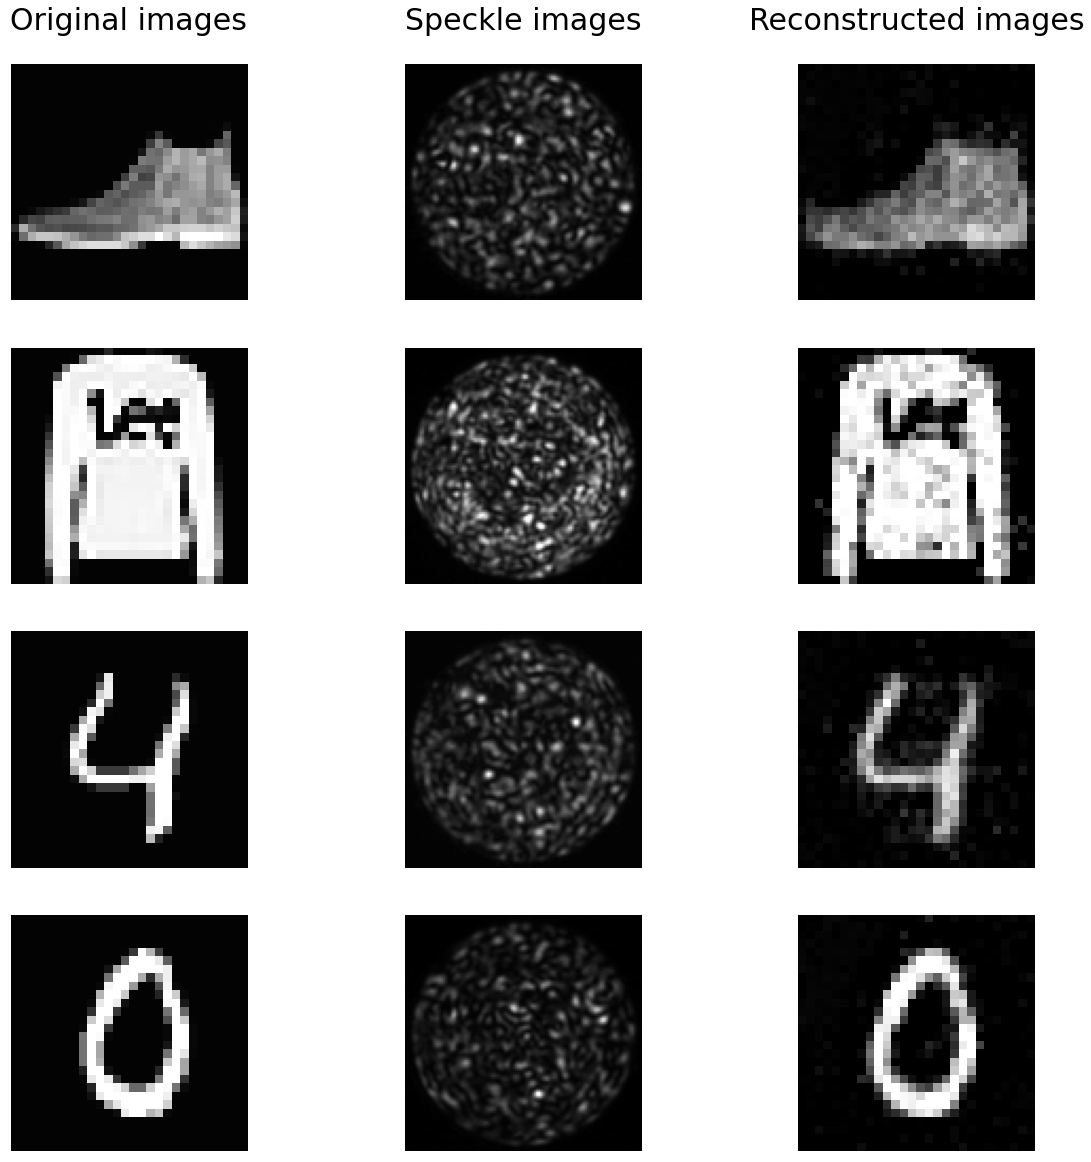

In [12]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = MyComplexDense(12544, 784)
        self.hadamard = MyHadamard(784)
        self.amplitude = MyAmplitude()

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        x = self.amplitude(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Complex_L2_reg_SSIM'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss_train = SSIM_loss(mul = 20e3, channel=1, win_sigma = 5)
loss_test = nn.MSELoss()

#Train and save the model
epochs = 1000
lamb = 0.03
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss_train, reg = 'L2', lamb = lamb, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_lamb_{}_relu'.format(epochs, lamb))

#Test the model
#net = torch.load('models/' + model_name + '_epoch_{}_lamb_{}'.format(epochs, lamb)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss_test)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.6 Model_6: Complex layer with Semi-Unitary regularization

Net(
  (fc): MyComplexDense(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
  (amplitude): MyAmplitude()
)
Epoch: 1/1000, The current training loss = 5269.886630036111
The current validation loss: 3245.3766284699136
trigger times: 0
Epoch: 2/1000, The current training loss = 4858.77320968273
The current validation loss: 2737.70778185256
trigger times: 0
Epoch: 3/1000, The current training loss = 4610.416518100473
The current validation loss: 2448.434822244847
trigger times: 0
Epoch: 4/1000, The current training loss = 4432.336718891942
The current validation loss: 2252.910622454704
trigger times: 0
Epoch: 5/1000, The current training loss = 4292.615567229514
The current validation loss: 2115.7895598715922
trigger times: 0
Epoch: 6/1000, The current training loss = 4176.694397682368
The current validation loss: 2002.0969588908742
trigger times: 0
Epoch: 7/1000, The current training loss = 4077.6062196243643
The current validation loss: 19

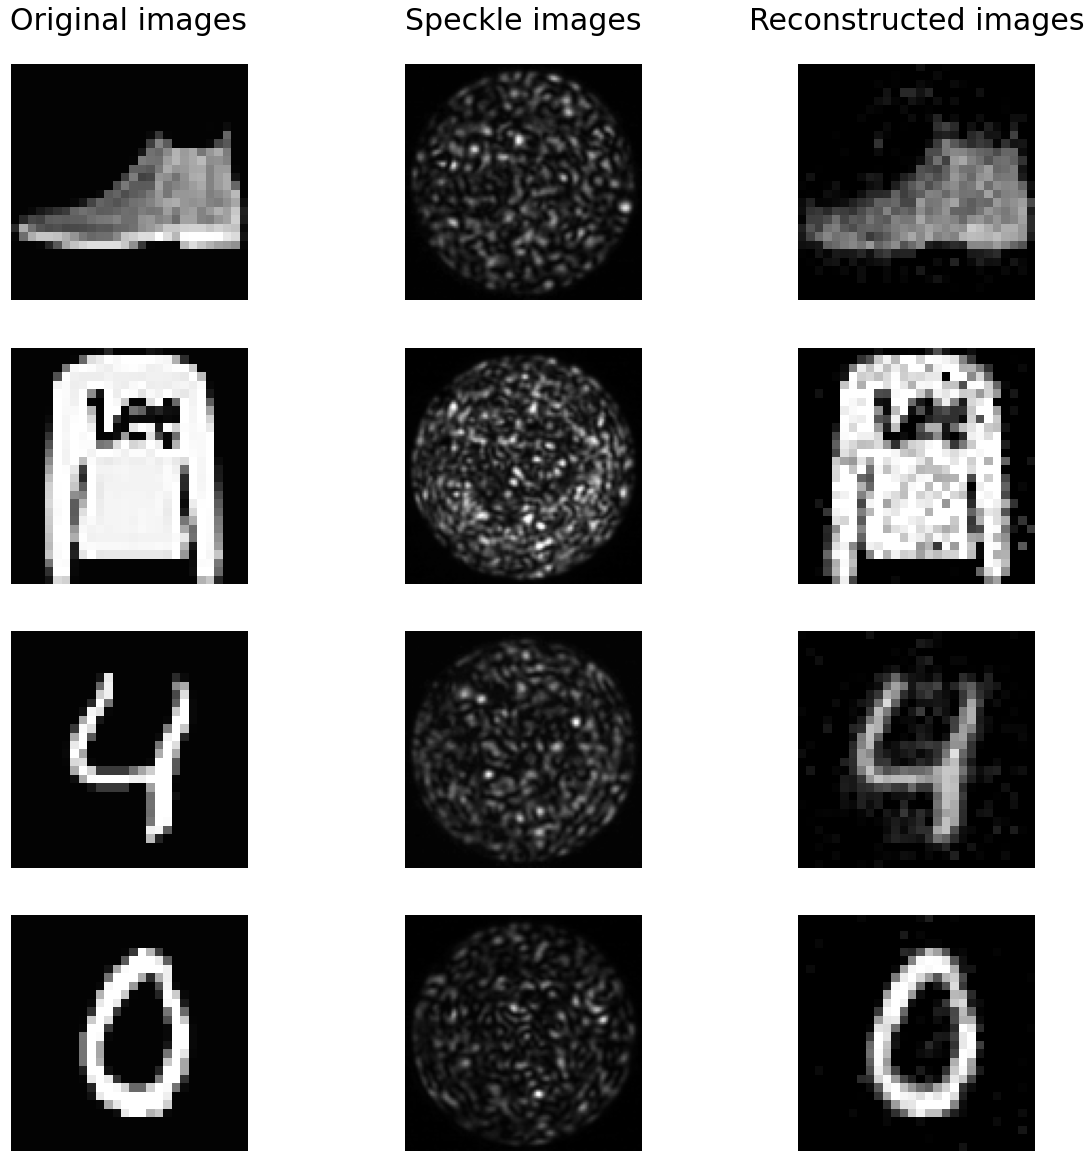

In [13]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = MyComplexDense(12544, 784)
        self.hadamard = MyHadamard(784)
        self.amplitude = MyAmplitude()

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        x = self.amplitude(x)
        return x
    
net = Net(); net.to(device); print(net)
model_name = 'Complex_Unitary_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
lamb = 0.03
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'Unitary', lamb = lamb, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_lamb_{}_relu'.format(epochs, lamb))

#Test the model
#net = torch.load('models/' + model_name + '_epoch_{}_lamb_{}'.format(epochs, lamb)); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)

### 1.3.6.7 Model_7: Complex layer with multi-resolution training and no regularization

Net(
  (fc): MyComplexDense(in_features=12544, out_features=784)
  (hadamard): MyHadamard(in_features=784, out_features=784)
  (reshape): MyReshape(in_size=784, out_size=28x28)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=2)
  (amplitude): MyAmplitude()
)
Epoch: 1/1000, The current training loss = 5036.315364394077
The current validation loss: 2792.8819632022937
trigger times: 0
Epoch: 2/1000, The current training loss = 4632.120049055233
The current validation loss: 2316.068863239694
trigger times: 0
Epoch: 3/1000, The current training loss = 4418.388435186342
The current validation loss: 2090.8064692071143
trigger times: 0
Epoch: 4/1000, The current training loss = 4254.727645519168
The current validation loss: 1939.1140305539395
trigger times: 0
Epoch: 5/1000, The current training loss = 4108.019874395326
The current validation loss: 1806.1572460418051
trigger times: 0
Epoch: 6/1000, The current training loss = 4009.2792610345887


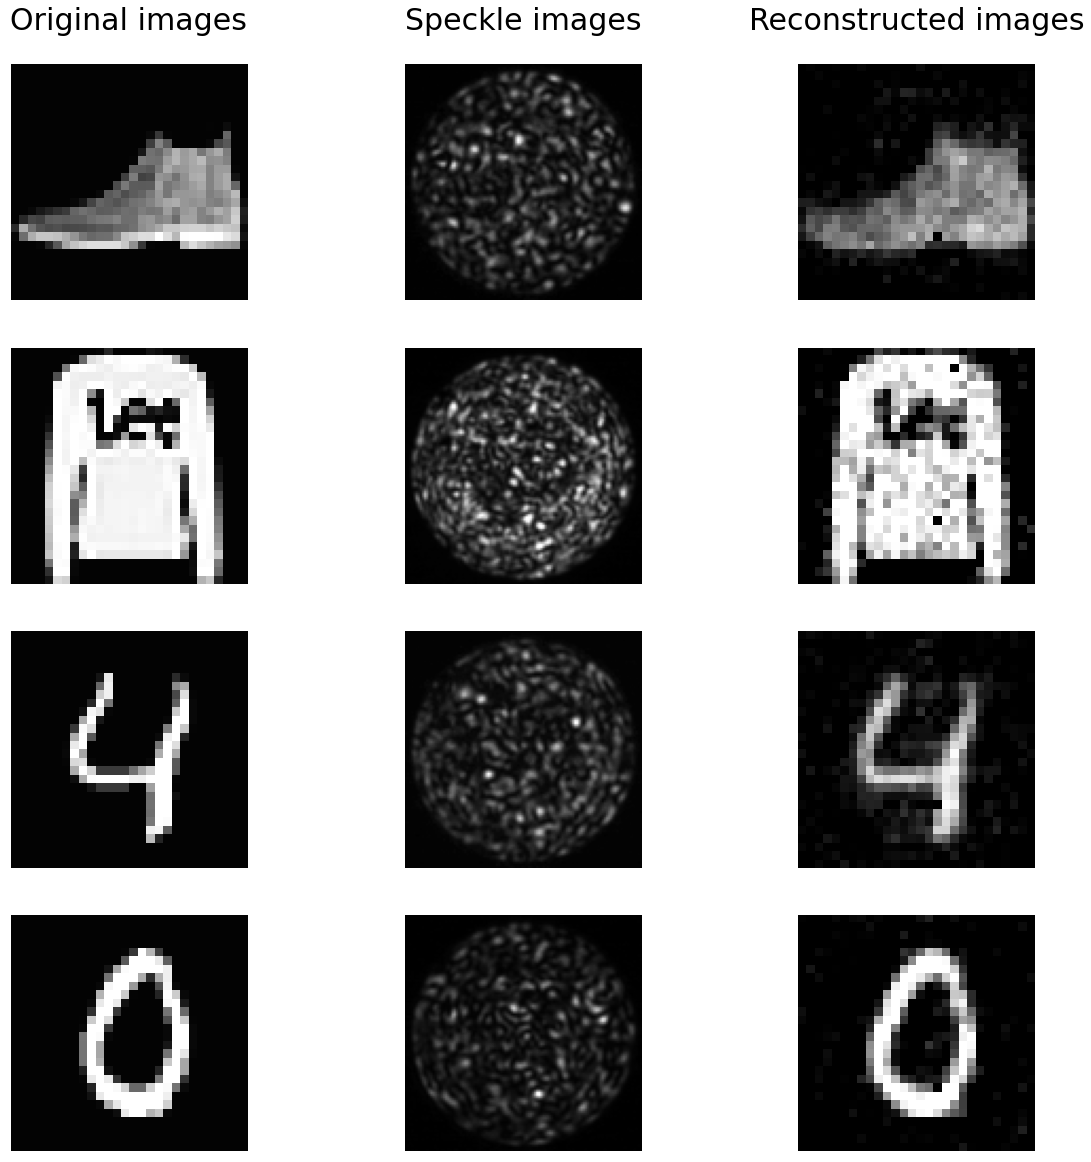

In [9]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = MyComplexDense(12544, 784)
        self.hadamard = MyHadamard(784)
        self.reshape = MyReshape(28, 28)
        self.pool = nn.AvgPool2d(2)
        self.flatten = nn.Flatten(start_dim=1, end_dim=2)
        self.amplitude = MyAmplitude()

    def forward(self, x):
        # First output
        x = self.fc(x)
        x = F.relu(x)
        x = self.hadamard(x)
        x0 = self.amplitude(x)
        
        # Second output
        x = self.reshape(x)
        x_real_pool = self.pool(x[:,:,:,0])
        x_imag_pool = self.pool(x[:,:,:,1])
        x = torch.stack((x_real_pool, x_imag_pool), dim = 3)
        x1 = self.flatten(x)
        x1 = self.amplitude(x1)

        # Third output
        x_real_pool = self.pool(x[:,:,:,0])
        x_imag_pool = self.pool(x[:,:,:,1])
        x = torch.stack((x_real_pool, x_imag_pool), dim = 3)
        x2 = self.flatten(x)
        x2 = self.amplitude(x2)
        
        return (x0, x1, x2)
    
net = Net(); net.to(device); print(net)
model_name = 'Complex_MultiRes_no_reg'
learning_rate = 1e-5
optimizer = optim.SGD(net.parameters() ,lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = 'min', factor = 0.1, patience = 2, min_lr = learning_rate/1e3, verbose = 1)
loss = nn.MSELoss()

#Train and save the model
epochs = 1000
train(model = net, epochs = epochs, optimizer = optimizer, scheduler = scheduler, loss = loss, reg = 'Unitary', lamb = 0.03, train_loader = train_loader, patience = 8, min_delta = 1e-4)
torch.save(net, 'models/' + model_name + '_epoch_{}_relu'.format(epochs))

#Test the model
#net = torch.load('models/' + 'model_name + '_epoch_{}'.format(epochs)'); net.to(device)
test(model = net, test_loader = test_loader, loss = loss)
test_display(model = net, x_test_all = x_test_ch, y_test_all = y_test)